In [1]:
import pickle
import pandas as pd
import numpy as np
import nltk
import gensim 
import string
from gensim.models import LdaModel
from gensim.corpora import Dictionary
pd.set_option('display.max_colwidth', 500)

In [2]:
with open('outputs.pickle', 'rb') as handle:
    outputs = pickle.load(handle)
train = outputs['df_train_merge']
test = outputs['df_test_merge']

In [3]:
test.columns

Index(['Date', 'Time', 'Training/Test', 'Title', 'Link', 'Abstract',
       'tweet_id', 'external_url', 'tweet_found', 'user_name', 'mentions',
       'medias', 'hashtags', 'in_reply_to_status_id',
       'in_reply_to_screen_name', 'in_reply_to_status_text',
       'external_url_title', 'New_Title', 'ab_clean', 'numbers', 'zero_length',
       'nouns', 'neg_noun_I', 'neg_noun_you', 'neg_noun_i', 'neg_noun_me',
       'neg_noun_we', 'neg_noun_they', 'neg_noun_It', 'neg_noun_You', 'nnp',
       'word_recall', 'word_alert', 'word_allergy', 'word_outbreak',
       'hashtag_RECALL', 'hashtag_Recall', 'hashtag_SmartNews',
       'mention_googlenews', 'num_words', 'user_name_words',
       'user_name_word_News', 'has_media', 'question_mark', 'preds',
       'pred_probs', 'has_recall'],
      dtype='object')

# 新增Predicted Event ID列

In [4]:
test['Predicted Event ID'] = np.NaN

 # 移除爬取到的title中一些XXX on Twitter等无用词

In [5]:
def remove_pre(text):
    text = str(text)
    index = text.find(":")
    if index != -1:
        return text[index + 1:]
    else:
        return text

In [6]:
test['New_Title'] = test['New_Title'].apply(remove_pre)

# 第一次分词：从整个TestSet中找出垃圾词

In [7]:
def getTokens_noGarbage(all_command):
    handle_all_command = []
    lines = all_command.tolist()
    stopwords = set(nltk.corpus.stopwords.words("english"))
    table = str.maketrans("","",string.punctuation)
    for line in lines:
        line = " ".join([word for word in str(line).split(" ") if '@' not in word and 'http' not in word and "RT" not in word])
        tokens = nltk.word_tokenize(line)
        tokens = [w.lower() for w in tokens]
        tokens = [w.translate(table) for w in tokens]
        tokens = [w for w in tokens if w.isalpha()]
        tokens = [w for w in tokens if w not in stopwords]
        handle_all_command.append(tokens)
    return handle_all_command

In [8]:
%time tokens = getTokens_noGarbage(test["New_Title"]) 

CPU times: user 5.18 s, sys: 21.1 ms, total: 5.21 s
Wall time: 5.21 s


# 将词频小于等于3的或者单词长度<3的单词作为垃圾词添

In [9]:
from collections import Counter

freq = Counter()
for ab in tokens:
    freq.update(ab)
    
garbage = []
for k, v in freq.items():
    if v <= 3 or len(k) < 3:
        garbage.append(k)

# 对数据进行二次分词，这次剔除掉垃圾词

In [10]:
def getTokens_withGarbage(all_command):
    handle_all_command = []
    lines = all_command.tolist()
    stopwords = set(nltk.corpus.stopwords.words("english"))
    table = str.maketrans("","",string.punctuation)
    for line in lines:
        line = " ".join([word for word in str(line).split(" ") if '@' not in word and 'http' not in word and "RT" not in word])
        tokens = nltk.word_tokenize(line)
        tokens = [w.lower() for w in tokens]
        tokens = [w.translate(table) for w in tokens]
        tokens = [w for w in tokens if w.isalpha()]
        tokens = [w for w in tokens if w not in stopwords and w not in garbage]
        handle_all_command.append(tokens)
    return handle_all_command

In [11]:
%time test['tokens'] = getTokens_withGarbage(test["New_Title"])
test['len'] = [len(to) for to in test['tokens']]

CPU times: user 1min 25s, sys: 204 ms, total: 1min 25s
Wall time: 1min 25s


# 将所有分词个数<=3的record的预测值置False

In [12]:
print(len(test[test['preds'] == True]), len(test[(test['preds'] == True) & (test['len'] > 3)]))

2289 2225


In [13]:
test.loc[test['len'] <= 3, 'preds'] = np.False_
len(test[test['preds'] == True])

2225

# 用LDA-mallet模型把preds为True的record进行话题分析

In [41]:
all_sent = test[test['preds'] == True]['tokens']
dic = Dictionary(all_sent)
corpus = [dic.doc2bow(text) for text in all_sent]

# %time lda = LdaModel(corpus=corpus, id2word=dic, num_topics=14, passes=100, random_state=42) 

In [45]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

# 通过计算coherence来选出得分高的模型

In [53]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
%time model_list, coherence_values = compute_coherence_values(dictionary=dic, corpus=corpus, texts=all_sent, start=10, limit=20, step=1)


CPU times: user 12.5 s, sys: 920 ms, total: 13.4 s
Wall time: 7min 4s


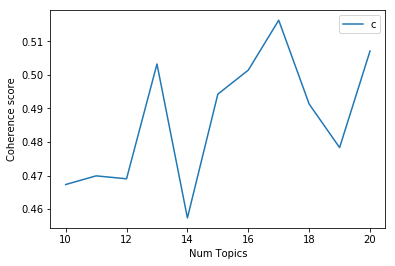

In [55]:
import matplotlib.pyplot as plt

limit=20; start=10; step=1;
x = range(start, limit + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# 取17作为topic数

In [58]:
lda = model_list[-4]

In [69]:
lda.print_topics(num_topics=17, num_words=10)

[(0,
  '0.350*"food" + 0.084*"safety" + 0.026*"unsafe" + 0.020*"launched" + 0.017*"tools" + 0.016*"allergy" + 0.016*"businesses" + 0.016*"people" + 0.016*"withdrawing" + 0.015*"allergies"'),
 (1,
  '0.368*"due" + 0.248*"salmonella" + 0.230*"contamination" + 0.020*"potential" + 0.017*"concerns" + 0.006*"bakers" + 0.005*"word" + 0.004*"columbus" + 0.004*"safe" + 0.004*"companies"'),
 (2,
  '0.266*"salmonella" + 0.257*"due" + 0.209*"concerns" + 0.052*"pounds" + 0.032*"announced" + 0.014*"traces" + 0.013*"sausage" + 0.013*"bag" + 0.012*"pork" + 0.011*"tampering"'),
 (3,
  '0.121*"unbleached" + 0.108*"recall" + 0.092*"company" + 0.079*"select" + 0.066*"hometown" + 0.064*"purpose" + 0.043*"food" + 0.040*"allpurpose" + 0.040*"voluntary" + 0.028*"announced"'),
 (4,
  '0.317*"recall" + 0.096*"product" + 0.025*"fda" + 0.025*"brand" + 0.024*"popular" + 0.023*"affected" + 0.019*"lots" + 0.017*"parent" + 0.015*"news" + 0.015*"potentially"'),
 (5,
  '0.267*"turkey" + 0.187*"ground" + 0.186*"butterba

# 将数据合并到整个TestSet

In [59]:
predID = []
for x in lda[corpus]:
    predID.append(sorted(x, key=lambda y: y[1], reverse=True)[0][0])

In [60]:
test.loc[test['preds'] == True, "Predicted Event ID"] = predID

In [61]:
test.sort_values("Predicted Event ID").head(5)

,Date,Time,Training/Test,Title,Link,Abstract,tweet_id,external_url,tweet_found,user_name,...,user_name_words,user_name_word_News,has_media,question_mark,preds,pred_probs,has_recall,Predicted Event ID,tokens,len
20749,2019-03-14,04:40:44,Test,Genetics of Food Allergy and Intolerance White blood cellular styles decided genetically and targeted as HLA DQ and…,https://twitter.com/tweet/status/1106052519019597825,Genetics of Food Allergy and Intolerance White blood cellular styles decided genetically and targeted as HLA DQ and… https://t.co/du0uK2rFXX,1106052519019597825,https://t.co/du0uK2rFXX,True,didbijckidas,...,[didbijckidas],False,False,0,True,0.736000,False,0.0,"[food, allergy, white, blood, styles, decided, genetically, targeted, genes, recognized, extended, hazard, pollen, dust, meals]",15
15867,2019-03-13,13:31:34,Test,Montreal bakery recalls food as being unsafe https://t.co/gA1dvcrzRr,https://twitter.com/tweet/status/1105823719287484416,Montreal bakery recalls food as being unsafe https://t.co/gA1dvcrzRr https://t.co/bakuQV5JDh,1105823719287484416,https://t.co/bakuQV5JDh,True,CTV Montreal,...,"[CTV, Montreal]",False,True,0,True,0.964088,True,0.0,"[montreal, bakery, recalls, food, unsafe]",5
7071,2019-03-09,00:41:51,Test,"RT @FAOWHOCodex: ?? | @SteveWearne Vice-Chair of #CodexAlimentarius at #gfsi19 talking about #food, food allergies, #foodsafety, priorities…",https://twitter.com/tweet/status/1104180463197929472,"RT @FAOWHOCodex: ?? | @SteveWearne Vice-Chair of #CodexAlimentarius at #gfsi19 talking about #food, food allergies, #foodsafety, priorities…",1104180463197929472,None,True,Anne Gerardi,...,"[Anne, Gerardi]",False,False,2,True,0.668428,False,0.0,"[codexalimentarius, talking, food, food, allergies, foodsafety]",6
7323,2019-03-10,22:14:32,Test,"Urgent recall: Tesco, Asda, & Lidl issue food safety fears – FULL LIST of affected foods https://t.co/WhOCGFLwZj",https://twitter.com/tweet/status/1104868164301668352,"Urgent recall: Tesco, Asda, & Lidl issue food safety fears – FULL LIST of affected foods https://t.co/WhOCGFLwZj https://t.co/2AKppnHMGG",1104868164301668352,https://t.co/2AKppnHMGG,True,Newslanes,...,[Newslanes],False,True,0,True,0.964088,True,0.0,"[urgent, recall, asda, lidl, issue, food, safety, fears, full, list, affected, foods]",12
11617,2019-03-12,21:20:41,Test,"so now that alabama wants to be drug test food stamp recipients, let's fondly recall how unsuccessful that was in f…",https://twitter.com/tweet/status/1105579388865785856,"so now that alabama wants to be drug test food stamp recipients, let's fondly recall how unsuccessful that was in f… https://t.co/OOf84MpqyG",1105579388865785856,https://t.co/OOf84MpqyG,False,,...,[],False,False,0,True,0.766051,True,0.0,"[alabama, wants, drug, test, food, stamp, recipients, let, recall]",9


# 写入csv文件

In [62]:
toCsv = test[test['preds'] == True]

In [63]:
top_3_topic_score = []
for x in lda[corpus]:
    top_3_topic_score.append(sorted(x, key=lambda y: y[1], reverse=True)[0: 3])

In [64]:
toCsv['top_3_topic_score'] = top_3_topic_score

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
toCsv.sort_values("Predicted Event ID").head(5)

,Date,Time,Training/Test,Title,Link,Abstract,tweet_id,external_url,tweet_found,user_name,...,user_name_word_News,has_media,question_mark,preds,pred_probs,has_recall,Predicted Event ID,tokens,len,top_3_topic_score
20749,2019-03-14,04:40:44,Test,Genetics of Food Allergy and Intolerance White blood cellular styles decided genetically and targeted as HLA DQ and…,https://twitter.com/tweet/status/1106052519019597825,Genetics of Food Allergy and Intolerance White blood cellular styles decided genetically and targeted as HLA DQ and… https://t.co/du0uK2rFXX,1106052519019597825,https://t.co/du0uK2rFXX,True,didbijckidas,...,False,False,0,True,0.736000,False,0.0,"[food, allergy, white, blood, styles, decided, genetically, targeted, genes, recognized, extended, hazard, pollen, dust, meals]",15,"[(0, 0.089693313222725), (12, 0.0725992961287079), (14, 0.0725992961287079)]"
15867,2019-03-13,13:31:34,Test,Montreal bakery recalls food as being unsafe https://t.co/gA1dvcrzRr,https://twitter.com/tweet/status/1105823719287484416,Montreal bakery recalls food as being unsafe https://t.co/gA1dvcrzRr https://t.co/bakuQV5JDh,1105823719287484416,https://t.co/bakuQV5JDh,True,CTV Montreal,...,False,True,0,True,0.964088,True,0.0,"[montreal, bakery, recalls, food, unsafe]",5,"[(0, 0.12418300653594766), (10, 0.07165775401069517), (11, 0.055496137849079016)]"
7071,2019-03-09,00:41:51,Test,"RT @FAOWHOCodex: ?? | @SteveWearne Vice-Chair of #CodexAlimentarius at #gfsi19 talking about #food, food allergies, #foodsafety, priorities…",https://twitter.com/tweet/status/1104180463197929472,"RT @FAOWHOCodex: ?? | @SteveWearne Vice-Chair of #CodexAlimentarius at #gfsi19 talking about #food, food allergies, #foodsafety, priorities…",1104180463197929472,None,True,Anne Gerardi,...,False,False,2,True,0.668428,False,0.0,"[codexalimentarius, talking, food, food, allergies, foodsafety]",6,"[(0, 0.10609243697478991), (10, 0.07037815126050419), (1, 0.06839402427637722)]"
7323,2019-03-10,22:14:32,Test,"Urgent recall: Tesco, Asda, & Lidl issue food safety fears – FULL LIST of affected foods https://t.co/WhOCGFLwZj",https://twitter.com/tweet/status/1104868164301668352,"Urgent recall: Tesco, Asda, & Lidl issue food safety fears – FULL LIST of affected foods https://t.co/WhOCGFLwZj https://t.co/2AKppnHMGG",1104868164301668352,https://t.co/2AKppnHMGG,True,Newslanes,...,False,True,0,True,0.964088,True,0.0,"[urgent, recall, asda, lidl, issue, food, safety, fears, full, list, affected, foods]",12,"[(0, 0.11016234450769553), (8, 0.09403331224963103), (4, 0.08507273877292854)]"
11617,2019-03-12,21:20:41,Test,"so now that alabama wants to be drug test food stamp recipients, let's fondly recall how unsuccessful that was in f…",https://twitter.com/tweet/status/1105579388865785856,"so now that alabama wants to be drug test food stamp recipients, let's fondly recall how unsuccessful that was in f… https://t.co/OOf84MpqyG",1105579388865785856,https://t.co/OOf84MpqyG,False,,...,False,False,0,True,0.766051,True,0.0,"[alabama, wants, drug, test, food, stamp, recipients, let, recall]",9,"[(0, 0.08278867102396514), (4, 0.08083935328517372), (11, 0.06524481137484234)]"


In [70]:
toCsv["Predicted Event ID"].value_counts()

9.0     241
5.0     198
7.0     195
8.0     159
3.0     156
11.0    148
0.0     135
16.0    128
13.0    123
10.0    123
4.0     110
1.0     104
12.0     91
2.0      89
6.0      88
14.0     78
15.0     59
Name: Predicted Event ID, dtype: int64

In [66]:
toCsv.columns

Index(['Date', 'Time', 'Training/Test', 'Title', 'Link', 'Abstract',
       'tweet_id', 'external_url', 'tweet_found', 'user_name', 'mentions',
       'medias', 'hashtags', 'in_reply_to_status_id',
       'in_reply_to_screen_name', 'in_reply_to_status_text',
       'external_url_title', 'New_Title', 'ab_clean', 'numbers', 'zero_length',
       'nouns', 'neg_noun_I', 'neg_noun_you', 'neg_noun_i', 'neg_noun_me',
       'neg_noun_we', 'neg_noun_they', 'neg_noun_It', 'neg_noun_You', 'nnp',
       'word_recall', 'word_alert', 'word_allergy', 'word_outbreak',
       'hashtag_RECALL', 'hashtag_Recall', 'hashtag_SmartNews',
       'mention_googlenews', 'num_words', 'user_name_words',
       'user_name_word_News', 'has_media', 'question_mark', 'preds',
       'pred_probs', 'has_recall', 'Predicted Event ID', 'tokens', 'len',
       'top_3_topic_score'],
      dtype='object')

In [68]:
toCsv =  toCsv[["New_Title", "external_url", "pred_probs", "Predicted Event ID", "top_3_topic_score",  "ab_clean", "tokens", "len"]]
toCsv.sort_values("Predicted Event ID").to_csv("17Topics.csv", index=False)